# Telecom Churn Case Study 

## The main goal of the case study is to build ML models to predict churn. 

### The predictive model that we are going to build will have the following purposes:

    A)  Data Pre-Processing: Missing value treatment, outlier removal, feature selection, and scaling.
    
	B)	Exploratory Data Analysis (EDA): Correlation analysis, visualizations, and key insights.
	
    C)	Feature Engineering: Transformation of categorical and numerical variables, creation of new features.
	
    D)	Model Building and Evaluation: Code for all attempted models, hyperparameter tuning, and evaluation metrics.
	
    E)	Final Model Selection: Clearly state why the chosen model is the best based on metrics.
	
    F)	Recommendations: Actionable insights to reduce churn based on your analysis

In [2]:
# Data Understanding, Preparation, and Pre-Processing


In [56]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
## Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
### Loading Datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
### Explore the Data Structure
print("Train Data Overview:")
print(train.head())
print(train.info())
print(train.describe())

print("\nTest Data Overview:")
print(test.head())
print(test.info())

Train Data Overview:
   id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0 

### Observation from the Data
a) The train dataset has 172 columns and 69999 rows.

b) The test dataset has 171 columns and 30000 rows.

c) The target column in the train data is churn_probability.

d) Potiential Outliers found to be seen on arpu_7. The values being extreme

### Data Types
Most Columns are numerical (int64 or float64 while few are categorical (object))

In [8]:
### Checking for Missing Values
print("\nMissing Values in Train Data:")
print(train.isnull().sum())

print("\nMissing Values in Test Data:")
print(test.isnull().sum())


Missing Values in Train Data:
id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64

Missing Values in Test Data:
id                    0
circle_id             0
loc_og_t2o_mou      316
std_og_t2o_mou      316
loc_ic_t2o_mou      316
                  ...  
fb_user_8         22078
aon                   0
aug_vbc_3g            0
jul_vbc_3g            0
jun_vbc_3g            0
Length: 171, dtype: int64


### Observation from the Missing Values

There are significant missing values found to be seen on columns like fb_user_8 in the Test Dataset


loc_og_t2o_mou, std_og_t2o_mou, and loc_ic_t2o_mou have 702 missing values in train and 316 in test.
fb_user_8 has over 22,000 missing values in test data.


### Handle Missing Values

We will use median to impute missing values for numerical columns

We will use mode to handle missing values on categorical columns

In [11]:
# Impute missing values for numerical columns using median
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('churn_probability', errors='ignore')  # Exclude target column if present

train[numerical_cols] = train[numerical_cols].fillna(train[numerical_cols].median())
test[numerical_cols] = test[numerical_cols].fillna(test[numerical_cols].median())

# Impute missing values for categorical columns using mode
categorical_cols = train.select_dtypes(include=['object']).columns
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])
test[categorical_cols] = test[categorical_cols].fillna(test[categorical_cols].mode().iloc[0])

# Verify that there are no missing values
print("Remaining Missing Values in Train Data:")
print(train.isnull().sum().sum())

print("Remaining Missing Values in Test Data:")
print(test.isnull().sum().sum())

Remaining Missing Values in Train Data:
0
Remaining Missing Values in Test Data:
0


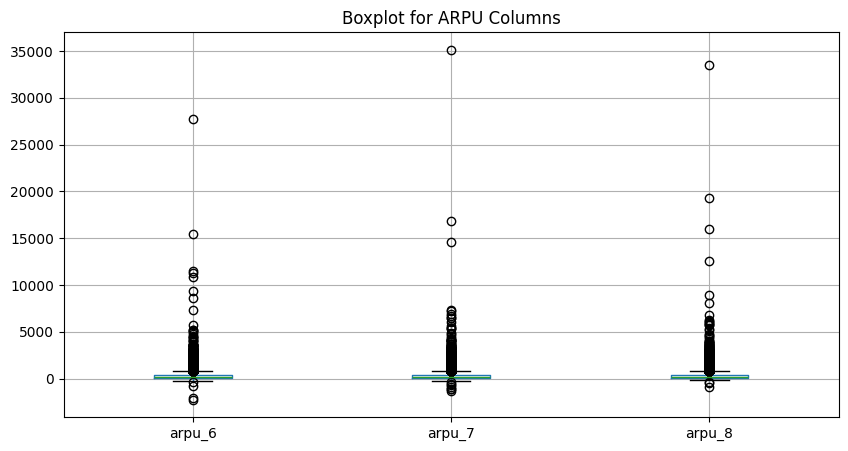

In [12]:
### Outliers Analysis and Handling

### We will check for outliers in some numerical columns suck as arpu_6, arpu_7 and arpu_8. We will visualize the distribution

# Visualize ARPU columns for outliers
arpu_columns = ['arpu_6', 'arpu_7', 'arpu_8']
train[arpu_columns].boxplot(figsize=(10, 5))
plt.title("Boxplot for ARPU Columns")
plt.show()

In [14]:
### Identify Outliers threshold
## We will use the 5th and 95th percentile to cap the data. It will limit most of the data while limiting the influence of extreme values.

# Calculate the 5th and 95th percentiles for ARPU columns
for col in ['arpu_6', 'arpu_7', 'arpu_8']:
    lower_limit = train[col].quantile(0.05)
    upper_limit = train[col].quantile(0.95)
    print(f"{col}: Lower Limit = {lower_limit}, Upper Limit = {upper_limit}")


arpu_6: Lower Limit = 1.5, Upper Limit = 832.0226999999998
arpu_7: Lower Limit = 0.9190000000000009, Upper Limit = 823.2366999999982
arpu_8: Lower Limit = 0.0, Upper Limit = 828.4646999999983


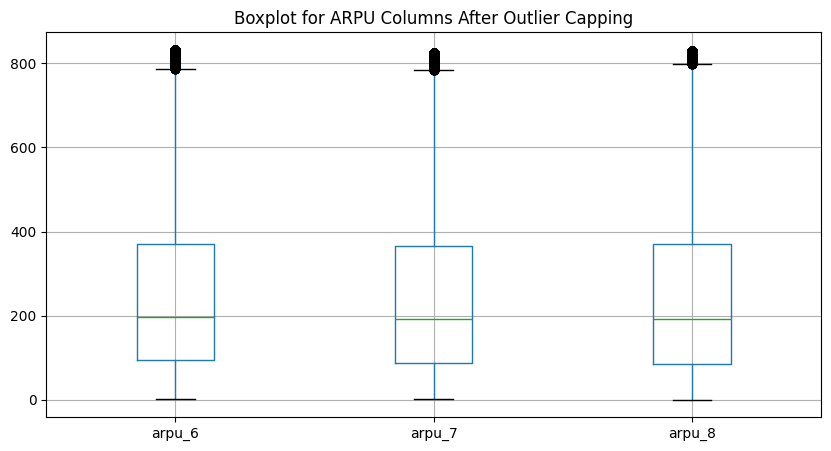

In [16]:
### Cap the Outliers

# Cap the outliers at the calculated thresholds
outlier_limits = {
    'arpu_6': (1.5, 832.0227),
    'arpu_7': (0.919, 823.2367),
    'arpu_8': (0.0, 828.4647)
}

for col, (lower_limit, upper_limit) in outlier_limits.items():
    train[col] = train[col].clip(lower=lower_limit, upper=upper_limit)
    test[col] = test[col].clip(lower=lower_limit, upper=upper_limit)

# Verify boxplots after capping
train[['arpu_6', 'arpu_7', 'arpu_8']].boxplot(figsize=(10, 5))
plt.title("Boxplot for ARPU Columns After Outlier Capping")
plt.show()

### Observations ###

1. Boxplots:

     a) The Extreme outliers have been capped at the 95th percentile
  
     b) The boxplots shows a resonable spread of data, making the dataset less likely to be distored by the extreme values.

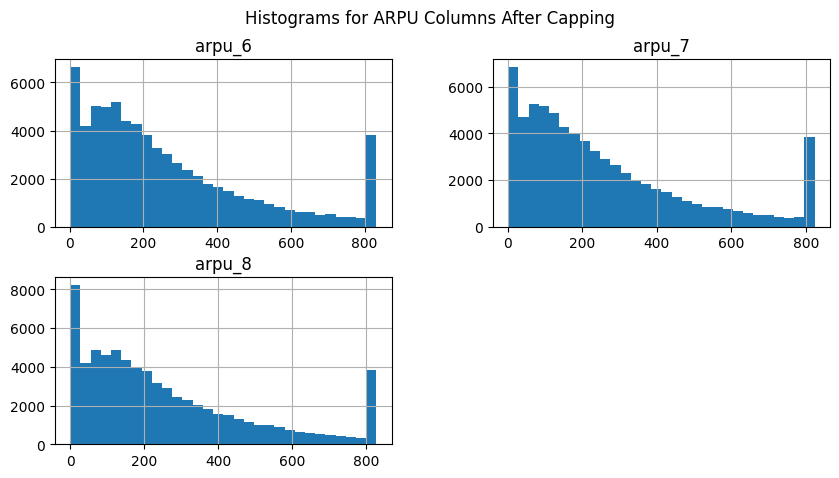

In [17]:
### Validate Distributions

# Plot histograms to verify the capped distributions
train[['arpu_6', 'arpu_7', 'arpu_8']].hist(figsize=(10, 5), bins=30)
plt.suptitle("Histograms for ARPU Columns After Capping")
plt.show()

### Observations ###

2. Histogram:

     a) The capped appear as spiked at the upper threshold.

     b) the majority of data remains well distributed across the lower and middle ranges.

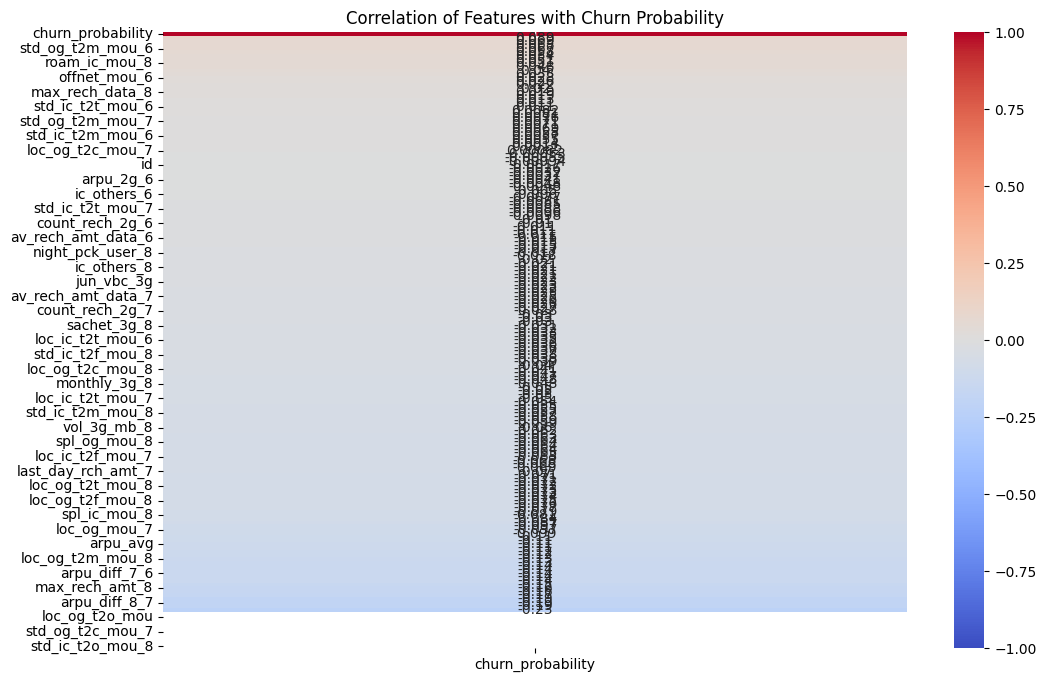

In [28]:
# Select only numeric columns for correlation
numeric_cols = train.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap for top features correlated with churn
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['churn_probability']].sort_values(by='churn_probability', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Features with Churn Probability")
plt.show()

In [30]:
# Check the shape of each column
print(train['arpu_diff_7_6'].shape)
print(train['arpu_diff_8_7'].shape)
print(train['churn_probability'].shape)

(69999, 2)
(69999, 2)
(69999,)


In [33]:
print(train['arpu_diff_7_6'].shape)
print(train['arpu_diff_8_7'].shape)

# Examine the first few rows
print(train['arpu_diff_7_6'].head())
print(train['arpu_diff_8_7'].head())

(69999, 2)
(69999, 2)
   arpu_diff_7_6  arpu_diff_7_6
0         55.732         55.732
1        121.287        121.287
2         42.370         42.370
3         48.898         48.898
4       -112.517       -112.517
   arpu_diff_8_7  arpu_diff_8_7
0        -79.482        -79.482
1        -79.834        -79.834
2       -103.176       -103.176
3        -94.165        -94.165
4        -26.626        -26.626


In [38]:
# Recalculate ARPU differences directly from source columns
train['arpu_diff_7_6'] = train['arpu_7'] - train['arpu_6']
train['arpu_diff_8_7'] = train['arpu_8'] - train['arpu_7']

In [39]:
# Check the shape of the corrected columns
print(train['arpu_diff_7_6'].shape)
print(train['arpu_diff_8_7'].shape)

# Check the first few rows
print(train[['arpu_diff_7_6', 'arpu_diff_8_7']].head())

(69999, 2)
(69999, 2)
   arpu_diff_7_6  arpu_diff_7_6  arpu_diff_8_7  arpu_diff_8_7
0         55.732         55.732        -79.482        -79.482
1        121.287        121.287        -79.834        -79.834
2         42.370         42.370       -103.176       -103.176
3         48.898         48.898        -94.165        -94.165
4       -112.517       -112.517        -26.626        -26.626


In [40]:
# Drop the problematic columns
train = train.drop(columns=['arpu_diff_7_6', 'arpu_diff_8_7'], errors='ignore')

In [41]:
# Recalculate the ARPU difference columns
train['arpu_diff_7_6'] = train['arpu_7'] - train['arpu_6']
train['arpu_diff_8_7'] = train['arpu_8'] - train['arpu_7']

In [42]:
# Check the shape of the new columns
print(train['arpu_diff_7_6'].shape)
print(train['arpu_diff_8_7'].shape)

# Check the first few rows of the new columns
print(train[['arpu_diff_7_6', 'arpu_diff_8_7']].head())

(69999,)
(69999,)
   arpu_diff_7_6  arpu_diff_8_7
0         55.732        -79.482
1        121.287        -79.834
2         42.370       -103.176
3         48.898        -94.165
4       -112.517        -26.626


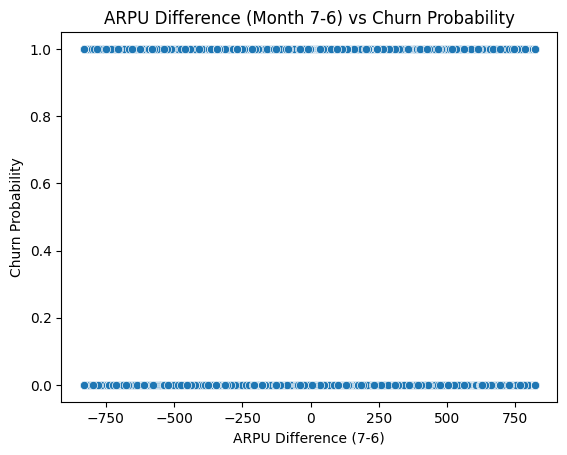

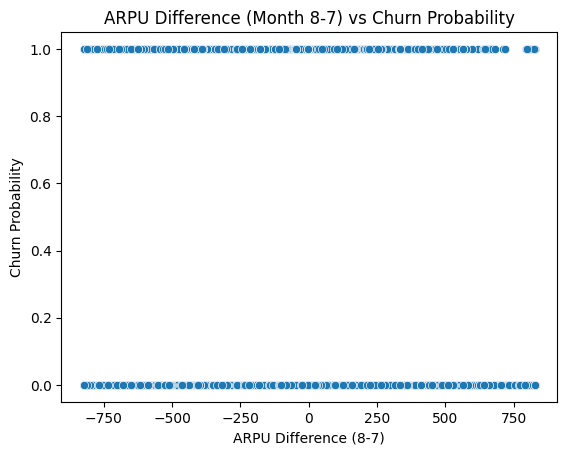

In [43]:
# Scatterplot for ARPU Difference (7-6)
sns.scatterplot(x='arpu_diff_7_6', y='churn_probability', data=train)
plt.title("ARPU Difference (Month 7-6) vs Churn Probability")
plt.xlabel("ARPU Difference (7-6)")
plt.ylabel("Churn Probability")
plt.show()

# Scatterplot for ARPU Difference (8-7)
sns.scatterplot(x='arpu_diff_8_7', y='churn_probability', data=train)
plt.title("ARPU Difference (Month 8-7) vs Churn Probability")
plt.xlabel("ARPU Difference (8-7)")
plt.ylabel("Churn Probability")
plt.show()

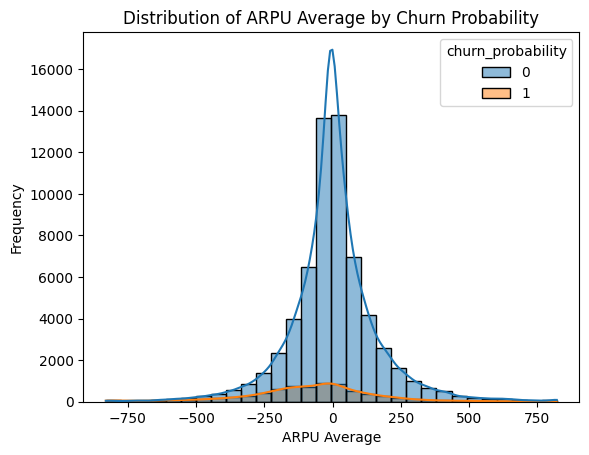

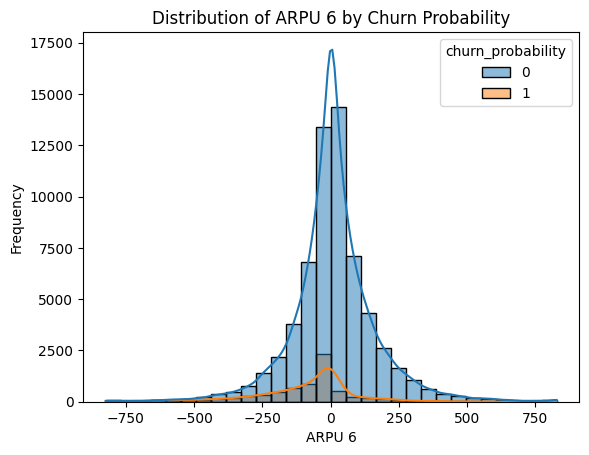

In [45]:
### Exploratory Data Analysis (EDA) ###

### Analyze Distribution of Key Features
sns.histplot(data=train, x='arpu_diff_7_6', hue='churn_probability', kde=True, bins=30)
plt.title("Distribution of ARPU Average by Churn Probability")
plt.xlabel("ARPU Average")
plt.ylabel("Frequency")
plt.show()

sns.histplot(data=train, x='arpu_diff_8_7', hue='churn_probability', kde=True, bins=30)
plt.title("Distribution of ARPU 6 by Churn Probability")
plt.xlabel("ARPU 6")
plt.ylabel("Frequency")
plt.show()

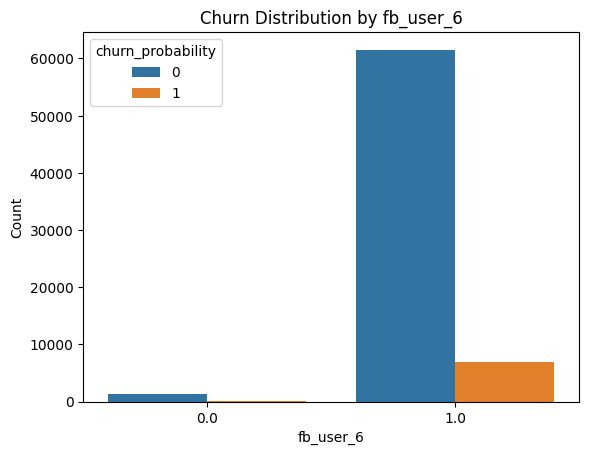

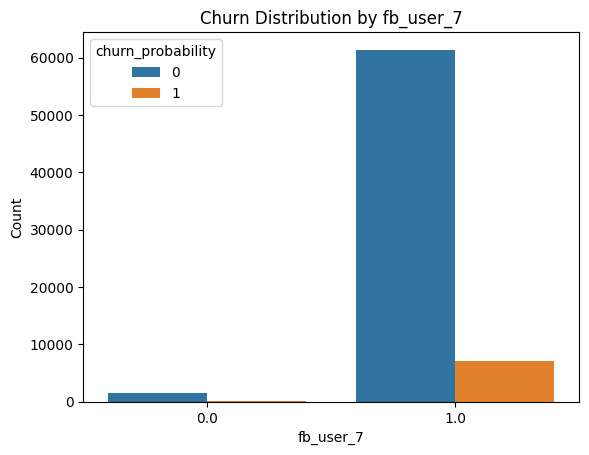

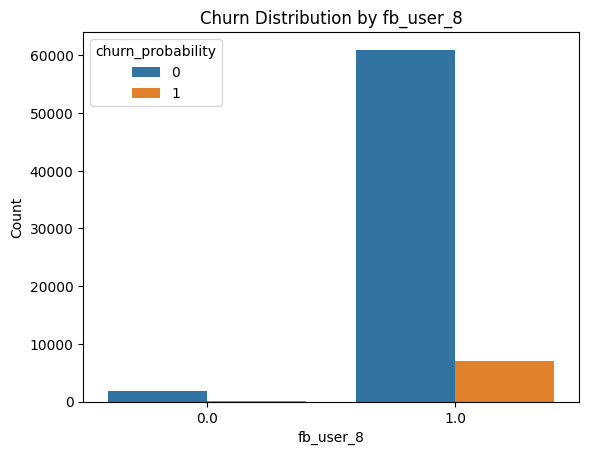

In [46]:
### Analyze categorical variable

categorical_features = ['fb_user_6', 'fb_user_7', 'fb_user_8']

for col in categorical_features:
    sns.countplot(data=train, x=col, hue='churn_probability')
    plt.title(f"Churn Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

### Observations from the Plots

1. ARPU Distributions
	•	The ARPU Difference (7-6) and ARPU Difference (8-7) distributions show that most customers (churners and non-churners) have ARPU differences centered around zero, with a slight skew.
	•	Churners (churn_probability = 1) tend to have more pronounced ARPU differences, especially in the lower ranges, which could indicate a reduction in usage before churn.

2. Facebook User Distributions (fb_user_*)
	•	The bar plots for fb_user_6, fb_user_7, and fb_user_8 suggest that:
	•	Most customers who use Facebook (1.0) have a higher churn probability compared to non-users (0.0).
	•	This indicates that Facebook usage might correlate with churn behavior.

### Feature Engineering

In [48]:
# Aggregrate Usage Patterns
# Create ARPU average and total difference
train['arpu_total_diff'] = train['arpu_8'] - train['arpu_6']
train['arpu_avg_diff'] = (train['arpu_7'] - train['arpu_6'] + train['arpu_8'] - train['arpu_7']) / 2

In [49]:
# Categorical Encoding

# Impute missing values for fb_user_* columns with mode
categorical_features = ['fb_user_6', 'fb_user_7', 'fb_user_8']
for col in categorical_features:
    train[col] = train[col].fillna(train[col].mode()[0])

In [50]:
# Create a binary flag for significant drop in ARPU over months

# Binary feature for significant ARPU drop
train['arpu_drop_flag'] = ((train['arpu_7'] < train['arpu_6'] * 0.8) & (train['arpu_8'] < train['arpu_7'] * 0.8)).astype(int)

In [51]:
# Data Scaling

from sklearn.preprocessing import MinMaxScaler

# Scale ARPU-related features
scaler = MinMaxScaler()
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_total_diff', 'arpu_avg_diff']
train[arpu_cols] = scaler.fit_transform(train[arpu_cols])

### Model Building and Evaluation

In [52]:
### Train-Test Split

# Split the data into training and test sets to evaluate the model’s performance.

from sklearn.model_selection import train_test_split

# Define feature columns and target
feature_cols = ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_total_diff', 'arpu_avg_diff', 'arpu_drop_flag',
                'fb_user_6', 'fb_user_7', 'fb_user_8']
target_col = 'churn_probability'

# Split the data
X = train[feature_cols]
y = train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [53]:
# Baseline Logistics Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=500)
logreg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Print metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

Confusion Matrix:
[[18756   104]
 [ 1997   143]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     18860
           1       0.58      0.07      0.12      2140

    accuracy                           0.90     21000
   macro avg       0.74      0.53      0.53     21000
weighted avg       0.87      0.90      0.86     21000

ROC-AUC Score: 0.7933262306617377


In [54]:
# Random Forest Classifier

# It will handle feature importance and interactions better

from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Print metrics
print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Calculate ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"ROC-AUC Score (Random Forest): {roc_auc_rf}")


Confusion Matrix (Random Forest):
[[18484   376]
 [ 1317   823]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     18860
           1       0.69      0.38      0.49      2140

    accuracy                           0.92     21000
   macro avg       0.81      0.68      0.72     21000
weighted avg       0.91      0.92      0.91     21000

ROC-AUC Score (Random Forest): 0.8419670023091942


In [58]:
# Boost Classifier
# We will use thjis for better performance

from xgboost import XGBClassifier

# Initialize and train XGBoost
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Print metrics
print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Calculate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC-AUC Score (XGBoost): {roc_auc_xgb}")

Confusion Matrix (XGBoost):
[[18393   467]
 [ 1297   843]]

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     18860
           1       0.64      0.39      0.49      2140

    accuracy                           0.92     21000
   macro avg       0.79      0.68      0.72     21000
weighted avg       0.90      0.92      0.91     21000

ROC-AUC Score (XGBoost): 0.8319681792053597


### Final Model Selection

Based on the results for all the model, Random forest will be selected as the final model due to its high ROC-AUC, better precision and recall for churners

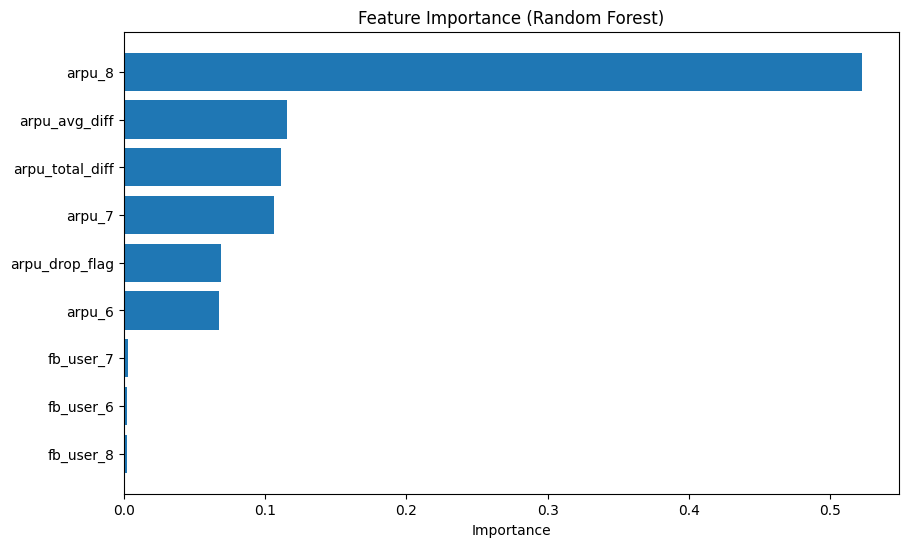

In [60]:
### Feature Importance Analysis

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

### Key Insights from Feature Importance:
	1.	arpu_8:
		The most important feature by far. The ARPU (average revenue per user) for month 8 has a substantial impact on churn prediction.    This suggests that customers’ recent ARPU is a critical indicator of their likelihood to churn.
	
    2.	arpu_avg_diff and arpu_total_diff:
		These aggregated differences in ARPU across months are also influential, highlighting that changes in spending behavior over time are strong churn predictors.
	
    3.	arpu_7 and arpu_6:
		While less important than arpu_8, ARPU for months 7 and 6 still contribute to predicting churn, reflecting customer behavior leading up to churn.
	
    4.	arpu_drop_flag:
		The binary flag indicating a significant drop in ARPU is also relevant. This aligns with the observation that a reduction in spending may signal churn risk.
	
    5.	fb_user_*:
		Facebook usage contributes minimally compared to ARPU features, but it could still be relevant for specific customer segments.

### Recommendations:

1. Focus on Customers with Low ARPU in Month 8
		Use targeted campaigns to retain customers whose ARPU in month 8 is significantly lower than average. Offer discounts, personalized plans, or incentives to maintain engagement.

2. Monitor ARPU Changes
		Proactively identify customers with decreasing ARPU over time (large negative arpu_avg_diff or arpu_total_diff) and intervene with retention strategies.

3. Address Sudden Drops in ARPU
		Customers with the arpu_drop_flag = 1 are at higher risk. Reach out to these customers to understand their declining usage and offer plans tailored to their needs.

4. Investigate Facebook User Patterns
		While fb_user_* features are less influential, consider analyzing these users’ engagement with other services to identify opportunities for cross-promotion or retention.

In [63]:
# Add the missing features to the test dataset
test['arpu_total_diff'] = test['arpu_8'] - test['arpu_6']
test['arpu_avg_diff'] = (test['arpu_7'] - test['arpu_6'] + test['arpu_8'] - test['arpu_7']) / 2
test['arpu_drop_flag'] = ((test['arpu_7'] < test['arpu_6'] * 0.8) & (test['arpu_8'] < test['arpu_7'] * 0.8)).astype(int)

In [64]:
# Scale Features in the Test Dataset
# Scale the test dataset using the same MinMaxScaler
test[arpu_cols] = scaler.transform(test[arpu_cols])

In [65]:
# Generate Predictions for the Test Dataset

# Predict churn probabilities on the test set
test['churn_probability'] = rf.predict_proba(test[feature_cols])[:, 1]

# Save the results in the submission file format
test[['id', 'churn_probability']].to_csv('submission.csv', index=False)